<a href="https://colab.research.google.com/github/m2gu3el/Paac-DL-project/blob/main/Paac_autoencoder_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, models, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,Input, Lambda, Reshape, Conv2DTranspose, GlobalAvgPool2D
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
!pip install astroNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 57.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
images, labels = load_galaxy10sdss()


Galaxy10.h5: 100%|█████████▉| 209M/210M [00:05<00:00, 49.1MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:05, 35.7MB/s]                           


In [ ]:
labels = to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)/255

In [ ]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
images_train , labels_train, images_test , labels_test  = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

In [ ]:
img_width  = images.shape[1]
img_height = images.shape[2]
img_width, img_height

(69, 69)

In [ ]:
print("images_train shape:", images_train.shape)
print("labels_train shape:", labels_train.shape)
print("images_test shape:", images_test.shape)
print("labels_test shape:", labels_test.shape)

images_train shape: (19606, 69, 69, 3)
labels_train shape: (19606, 10)
images_test shape: (2179, 69, 69, 3)
labels_test shape: (2179, 10)


In [ ]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [ ]:
y_train=y_train.flatten()
y_test=y_test.flatten()

In [ ]:
img_width  = X_train.shape[1]
img_height = X_train.shape[2]
img_width, img_height

(32, 32)

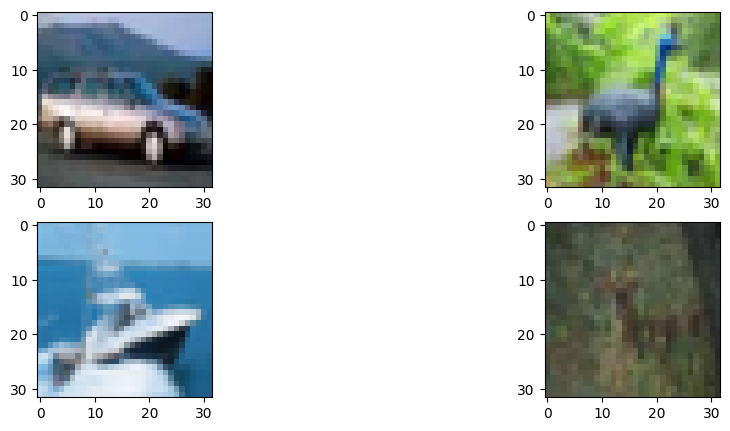

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(221)
plt.imshow(X_train[4][:,:,:])

plt.subplot(222)
plt.imshow(X_train[6][:,:,:])

plt.subplot(223)
plt.imshow(X_train[8][:,:,:])

plt.subplot(224)
plt.imshow(X_train[10][:,:,:])

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)  # one-hot encode the labels
y_test = to_categorical(y_test, 10)

###Variational Autoencoder

-> Instead of directly producing a coding
for a given input, the encoder produces a mean coding μ and a standard
deviation γ. The actual coding is then sampled randomly from a Gaussian
distribution with mean μ and standard deviation γ. After that the decoder
decodes the sampled coding normally.

### For Galaxy10

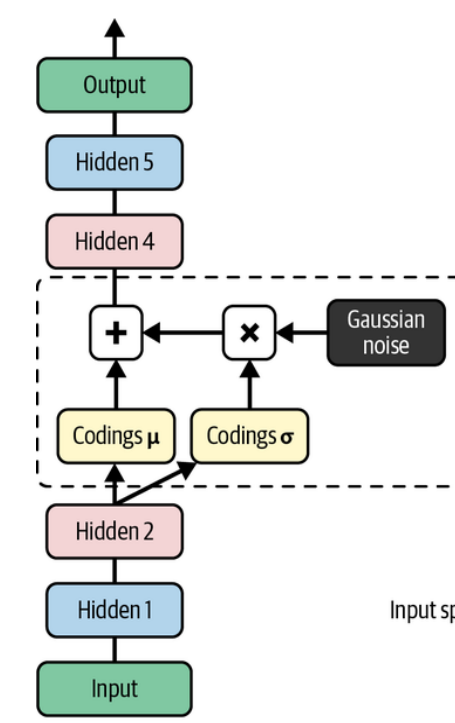

# Above is a representation of the structure of a Variational Autoencoder.
1. Input layer
2. Hidden layers- Conv2d and Dense
3. Dense layers splitting into - μ and γ i.e mean and variance
4. Sampling using gausian distribution- z= μ + eγ (encoder ends with z, μ , γ as outputs)
5. Hidden layers- Conv2dtranspose and dense.
6. Final output

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
codings_size = 2

inputs = Input(shape=(69,69,3), name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(3, 3))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape=tf.shape(x)

x = Flatten()(x)
x = Dense(150, activation="relu")(x)
x = Dense(100, activation="relu")(x)
codings_mean = Dense(codings_size)(x)  # μ
codings_log_var =Dense(codings_size)(x)  # γ
codings = Sampling()([codings_mean, codings_log_var]) # z
variational_encoder = models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
print(variational_encoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 69, 69, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 69, 69, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 23, 23, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 23, 23, 64)           36928     ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
decoder_inputs = Input(shape=(codings_size,), name='decoder_input')

x = Dense(23*23*64, activation='relu')(decoder_inputs)
x = Reshape((23,23,64))(x)

x=Conv2DTranspose(64,3, activation='relu', padding='same', strides=(3,3))(x)
x=Conv2DTranspose(3 ,3, activation='sigmoid', padding='same' )(x)              # Sigmoid for RGB images

variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=x)

In [ ]:
print(variational_decoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 33856)             101568    
                                                                 
 reshape (Reshape)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 69, 69, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 69, 69, 3)         1731      
 Transpose)                                                      
                                                                 
Total params: 140227 (547.76 KB)
Trainable params: 140227 (

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions]) # Combining encoder and decoder to form a VAE

# Formula for the latent loss in a variantional autoencoder
-> Here n is the coding size or latent dimensions which is 2

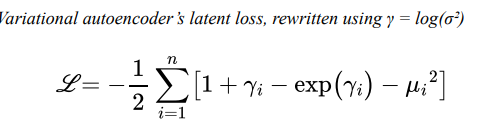

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / (69*69*3)) #  we divide the result by 69*69*3 to ensure it has the appropriate scale compared to the reconstruction loss

In [ ]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(images_train, images_train, epochs=25, batch_size=128, validation_data=(images_test, images_test))

Train on 19606 samples, validate on 2179 samples
Epoch 1/25
19606/19606 [==============================] - ETA: 0s - loss: 0.0267

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


19606/19606 [==============================] - 17s 866us/sample - loss: 0.0267 - val_loss: 0.0046
Epoch 2/25
19606/19606 [==============================] - 10s 535us/sample - loss: 0.0043 - val_loss: 0.0041
Epoch 3/25
19606/19606 [==============================] - 12s 591us/sample - loss: 0.0037 - val_loss: 0.0035
Epoch 4/25
19606/19606 [==============================] - 11s 548us/sample - loss: 0.0033 - val_loss: 0.0035
Epoch 5/25
19606/19606 [==============================] - 11s 571us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 6/25
19606/19606 [==============================] - 11s 582us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 7/25
19606/19606 [==============================] - 11s 545us/sample - loss: 0.0029 - val_loss: 0.0030
Epoch 8/25
19606/19606 [==============================] - 11s 555us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 9/25
19606/19606 [==============================] - 11s 564us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 10/25
19606/19606 [=====

In [ ]:
variational_ae.save('/content/VAE.py')

# Plotting results of VAE for Galaxy10

In [ ]:
reconstructed_images = variational_ae.predict(images_test)


indices_to_visualize = np.random.choice(len(images_test), size=5, replace=False)

# Plot the original and reconstructed images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices_to_visualize):

    plt.subplot(2, 5, i + 1)
    plt.imshow(images_test[idx])
    plt.title('Original')
    plt.axis('off')


    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[idx])
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()

### For CIFAR10


In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:


codings_size = 2

inputs2 = Input(shape=(32,32,3), name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(inputs2)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape2=tf.shape(x)

x = Flatten()(x)
x = Dense(150, activation="relu")(x)
x = Dense(100, activation="relu")(x)
codings_mean2 = Dense(codings_size)(x)  # μ
codings_log_var2 =Dense(codings_size)(x)  # γ
codings2 = Sampling()([codings_mean2, codings_log_var2]) # z
variational_encoder2 = models.Model(
    inputs=[inputs2], outputs=[codings_mean2, codings_log_var2, codings2])


In [ ]:
print(variational_encoder2.summary())

In [ ]:
decoder_inputs2 = Input(shape=(codings_size,))
x = Dense(16*16*64, activation='relu')(decoder_inputs2)
x = tf.keras.layers.Reshape((16,16,64))(x)
x=Conv2DTranspose(32,3, activation='relu', padding='same', strides=(2,2))(x)
x=Conv2DTranspose( 3 ,3, activation='sigmoid', padding='same' )(x)
variational_decoder2 = tf.keras.Model(inputs=[decoder_inputs2], outputs=x)

In [ ]:
_, _, codings2 = variational_encoder2(inputs2)
reconstructions2 = variational_decoder2(codings2)
variational_ae2 = tf.keras.Model(inputs=[inputs2], outputs=[reconstructions2]) # Combining encoder and decoder to form a VAE

In [ ]:
X_train.shape

In [ ]:
latent_loss2 = -0.5 * tf.reduce_sum(
    1 + codings_log_var2 - tf.exp(codings_log_var2) - tf.square(codings_mean2),
    axis=-1)
variational_ae2.add_loss(tf.reduce_mean(latent_loss2) /(32*32*3)) #  we divide the result by 32*32*3 to ensure it has the appropriate scale compared to the reconstruction loss


In [ ]:
variational_ae2.compile(loss="mse", optimizer="nadam")
history = variational_ae2.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_test, X_test))

# Ploting results of VAE for CIFAR10

In [ ]:
reconstructed_images2 = variational_ae2.predict(X_test)

indices_to_visualize = np.random.choice(len(X_test), size=5, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices_to_visualize):

    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title('Original')
    plt.axis('off')


    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images2[idx])
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Simple convolutional Autoencoder

-> Convolutional autoencoders are better suited for images as compared simple dense autoencoders.

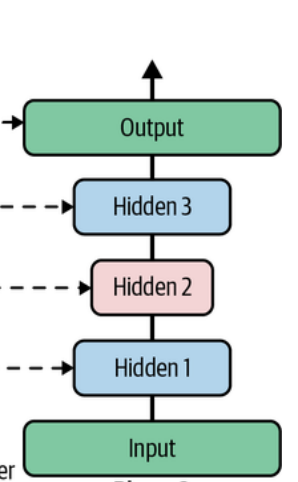

# Above is a representation of the structure of a simple convolutional Autoencoder.
1. Input layer
2. Hidden layers- Conv2d and MaxPooling
3. Global pooling average layer (encoder ends and decoder starts on the next step)
4. Hidden layers- Conv2dtranspose and dense and reshape
5. Final output

### For galaxy10

In [ ]:
conv_encoder = tf.keras.Sequential([
    Conv2D(16, 3, padding="same", activation="relu", input_shape=(69, 69, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(30, 3, padding="same", activation="relu"),
    GlobalAvgPool2D()
])


conv_decoder = tf.keras.Sequential([
    Input(shape=(30,)),
    Dense(23*23*64, activation="relu"),
    Reshape((23, 23, 64)),
    Conv2DTranspose(64, 3, strides=3, activation="relu", padding="same"),
    Conv2DTranspose(3, 3, strides=1, activation="sigmoid", padding="same"),  # Use sigmoid for RGB images
])


In [ ]:
print(conv_encoder.summary())

In [ ]:
print(conv_decoder.summary())

In [ ]:
# Combining Encoder and decoder to make an autoencoder
conv_ae = Sequential([conv_encoder, conv_decoder])

In [ ]:
conv_ae.compile(optimizer='nadam', loss='mse')

In [ ]:
conv_ae.fit(images_train, images_train, epochs=10, validation_data=(images_test, images_test))

In [ ]:
# Plotting original and reconstructed images
new_images = conv_ae.predict(images_test)

indices_to_visualize = np.random.choice(len(images_test), size=5, replace=False)


plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices_to_visualize):

    plt.subplot(2, 5, i + 1)
    plt.imshow(images_test[idx])
    plt.title('Original')
    plt.axis('off')


    plt.subplot(2, 5, i + 6)
    plt.imshow(new_images[idx])
    plt.title('new')
    plt.axis('off')

plt.tight_layout()
plt.show()

### For Cifar10

In [ ]:
conv_encoder2 = tf.keras.Sequential([
    Conv2D(16, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(30, 3, padding="same", activation="relu"),
    GlobalAvgPool2D()
])

conv_decoder2 = tf.keras.Sequential([
    Input(shape=(30,)),
    Dense(16*16*64, activation="relu"),
    Reshape((16, 16, 64)),
    Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"),
    Conv2DTranspose(3, 3, strides=1, activation="sigmoid", padding="same"),  # Use sigmoid for RGB images
])


In [ ]:
print(conv_decoder2.summary())

In [ ]:
# Combining Encoder and decoder to make an autoencoder
conv_ae2=Sequential([conv_encoder2, conv_decoder2])

In [ ]:
conv_ae2.compile(optimizer='nadam', loss='mse')

In [ ]:
conv_ae2.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test))

In [ ]:
new_images2 = conv_ae2.predict(X_test)


indices_to_visualize = np.random.choice(len(X_test), size=5, replace=False)


plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices_to_visualize):

    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(new_images2[idx])
    plt.title('new')
    plt.axis('off')

plt.tight_layout()
plt.show()